In [1]:
# !cd C:\Users\ASUS\Downloads\Malware-classification

C:\Users\ASUS\Downloads\Malware-classification


Before running this notebook, make sure to download the dataset first. The dataset used here is of Microsoft Malware Classification Challenge(2015), can be found in kaggle: https://www.kaggle.com/competitions/malware-classification

In [2]:
import warnings
warnings.filterwarnings("ignore")
import shutil
import os
import pandas as pd
import matplotlib
matplotlib.use(u'nbAgg')
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
from sklearn.manifold import TSNE
from sklearn import preprocessing
import pandas as pd
from multiprocessing import Process# this is used for multithreading
import multiprocessing
import codecs# this is used for file operations 
import random as r
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [3]:
source = 'Train'
destination = 'byteFiles'

if not os.path.isdir(destination):
    os.makedirs(destination)

if os.path.isdir(source):
    os.rename(source,'asmFiles')

In [4]:
# aggregate both asm and byte files into their respective folders
source='asmFiles'
data_files = os.listdir(source)
for file in data_files:
    if (file.endswith("bytes")):
        shutil.move(source+'\\'+file,destination)

## File size of Byte Files as a feature 

In [5]:
Y=pd.read_csv("trainLabels.csv")
files=os.listdir('byteFiles')
filenames=Y['Id'].tolist()
Malware=1
class_y=Y['Class'].tolist()
class_bytes=[]
sizebytes=[]
fnames=[]
for file in files:
    # create file beforehand on the directory, can use above cmd changing name of file
    statinfo=os.stat('byteFiles/'+file)
    # split the file name at '.' and take the first part of it i.e the file name
    file=file.split('.')[0]
    if any(file == filename for filename in filenames):
        i=filenames.index(file)
        class_bytes.append(class_y[i])
        # converting into Mb's
        sizebytes.append(statinfo.st_size/(1024.0*1024.0))
        fnames.append(file)
data_size_byte=pd.DataFrame({'ID':fnames,'size':sizebytes,'Class':class_bytes,'Malware':Malware})
print (data_size_byte.head())

                     ID      size  Class  Malware
0  01azqd4InC7m9JpocGv5  4.234863      9        1
1  01IsoiSMh5gxyDYTl4CB  5.538818      2        1
2  01jsnpXSAlgw6aPeDxrU  3.887939      9        1
3  01kcPWA9K2BOxQeS5Rju  0.574219      1        1
4  01SuzwMJEIXsK7A8dQbl  0.370850      8        1


## Feature Extraction from Byte Files

In [10]:
#removal of addres from byte files
# contents of .byte files
# ----------------
#00401000 56 8D 44 24 08 50 8B F1 E8 1C 1B 00 00 C7 06 08 
#-------------------
#we remove the starting address 00401000

files = os.listdir('byteFiles')
filenames=[]
array=[]
for file in files:
    if(file.endswith("bytes")):
        file=file.split('.')[0]
        text_file = open('byteFiles_txt/'+file+".txt", 'w+')
        file = file+'.bytes'
        with open('byteFiles/'+file,"r") as fp:
            lines=""
            for line in fp:
                a=line.rstrip().split(" ")[1:]
                b=' '.join(a)
                b=b+"\n"
                text_file.write(b)
            fp.close()
            #os.remove('byteFiles/'+file)
        text_file.close()

In [11]:
files = os.listdir('byteFiles_txt')
filenames2=[]
feature_matrix = np.zeros((len(files),257),dtype=int)
k=0
byte_feature_file=open('byteFiles.csv','w+')
byte_feature_file.write("ID,0,1,2,3,4,5,6,7,8,9,0a,0b,0c,0d,0e,0f,10,11,12,13,14,15,16,17,18,19,1a,1b,1c,1d,1e,1f,20,21,22,23,24,25,26,27,28,29,2a,2b,2c,2d,2e,2f,30,31,32,33,34,35,36,37,38,39,3a,3b,3c,3d,3e,3f,40,41,42,43,44,45,46,47,48,49,4a,4b,4c,4d,4e,4f,50,51,52,53,54,55,56,57,58,59,5a,5b,5c,5d,5e,5f,60,61,62,63,64,65,66,67,68,69,6a,6b,6c,6d,6e,6f,70,71,72,73,74,75,76,77,78,79,7a,7b,7c,7d,7e,7f,80,81,82,83,84,85,86,87,88,89,8a,8b,8c,8d,8e,8f,90,91,92,93,94,95,96,97,98,99,9a,9b,9c,9d,9e,9f,a0,a1,a2,a3,a4,a5,a6,a7,a8,a9,aa,ab,ac,ad,ae,af,b0,b1,b2,b3,b4,b5,b6,b7,b8,b9,ba,bb,bc,bd,be,bf,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,ca,cb,cc,cd,ce,cf,d0,d1,d2,d3,d4,d5,d6,d7,d8,d9,da,db,dc,dd,de,df,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9,ea,eb,ec,ed,ee,ef,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,fa,fb,fc,fd,fe,ff,??,")
byte_feature_file.write("\n")
for file in files:
    filenames2.append(file)
    byte_feature_file.write(file.split('.')[0]+",")
    if(file.endswith("txt")):
        with open('byteFiles_txt/'+file,"r") as byte_file:
            for lines in byte_file:
                line=lines.rstrip().split(" ")
                for hex_code in line:
                    if hex_code=='??':
                        feature_matrix[k][256]+=1
                    else:
                        feature_matrix[k][int(hex_code,16)]+=1
        byte_file.close()
    for i in feature_matrix[k]:
        byte_feature_file.write(str(i)+",")
    byte_feature_file.write("\n")
    
    k += 1

byte_feature_file.close()

In [ ]:
#For single file
'''
f_m = np.zeros((1,257),dtype=int)
f='0A32eTdBKayjCWhZqDOQ.txt'
b_f_f=open('r.csv','w+')
b_f_f.write("ID,0,1,2,3,4,5,6,7,8,9,0a,0b,0c,0d,0e,0f,10,11,12,13,14,15,16,17,18,19,1a,1b,1c,1d,1e,1f,20,21,22,23,24,25,26,27,28,29,2a,2b,2c,2d,2e,2f,30,31,32,33,34,35,36,37,38,39,3a,3b,3c,3d,3e,3f,40,41,42,43,44,45,46,47,48,49,4a,4b,4c,4d,4e,4f,50,51,52,53,54,55,56,57,58,59,5a,5b,5c,5d,5e,5f,60,61,62,63,64,65,66,67,68,69,6a,6b,6c,6d,6e,6f,70,71,72,73,74,75,76,77,78,79,7a,7b,7c,7d,7e,7f,80,81,82,83,84,85,86,87,88,89,8a,8b,8c,8d,8e,8f,90,91,92,93,94,95,96,97,98,99,9a,9b,9c,9d,9e,9f,a0,a1,a2,a3,a4,a5,a6,a7,a8,a9,aa,ab,ac,ad,ae,af,b0,b1,b2,b3,b4,b5,b6,b7,b8,b9,ba,bb,bc,bd,be,bf,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,ca,cb,cc,cd,ce,cf,d0,d1,d2,d3,d4,d5,d6,d7,d8,d9,da,db,dc,dd,de,df,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9,ea,eb,ec,ed,ee,ef,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,fa,fb,fc,fd,fe,ff,??,")
b_f_f.write('\n')
b_f_f.write(file.split('.')[0]+",")
if(f.endswith("txt")):
    with open('byteFiles_txt/'+f,"r") as b_f:
        for lines in b_f:
            line=lines.rstrip().split(" ")
            for hex_code in line:
                if hex_code=='??':
                    f_m[0][256]+=1
                else:
                    f_m[0][int(hex_code,16)]+=1
    b_f.close()
for i in f_m[0]:
    b_f_f.write(str(i)+",")
b_f_f.write("\n")
b_f_f.close()
bf=pd.read_csv("r.csv")
bf
'''

In [13]:
byte_features=pd.read_csv("byteFiles.csv")
result=byte_features.drop(columns=['Unnamed: 258'])
result

,ID,0,1,2,3,4,5,6,7,8,...,f7,f8,f9,fa,fb,fc,fd,fe,ff,??
0,01azqd4InC7m9JpocGv5,601905,3905,2816,3832,3345,3242,3650,3201,2965,...,2804,3687,3101,3211,3097,2758,3099,2759,5753,1824
1,01IsoiSMh5gxyDYTl4CB,39755,8337,7249,7186,8663,6844,8420,7589,9291,...,451,6536,439,281,302,7639,518,17001,54902,8588
2,01jsnpXSAlgw6aPeDxrU,93506,9542,2568,2438,8925,9330,9007,2342,9107,...,2325,2358,2242,2885,2863,2471,2786,2680,49144,468
3,01kcPWA9K2BOxQeS5Rju,21091,1213,726,817,1257,625,550,523,1078,...,478,873,485,462,516,1133,471,761,7998,13940
4,01SuzwMJEIXsK7A8dQbl,19764,710,302,433,559,410,262,249,422,...,847,947,350,209,239,653,221,242,2199,9008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3hYGWBHZ6iJr9X8KxENg,10736,5591,3305,3299,3303,3373,3368,3338,3253,...,3169,3210,3247,3218,3183,3142,3199,3295,7166,1493148
996,3I8UmNjSvVu5sblAYfXB,32359,1144,709,988,903,549,490,511,701,...,353,562,308,303,324,485,364,498,5138,12728
997,3i9xQwF8b4HMzcWZdKgq,10411,5534,3196,3277,3103,3287,3251,3265,3200,...,3191,3184,3192,3222,3153,3155,3143,3112,6855,1491100
998,3IBKiONtaWxXpQmufSZs,11304,5525,3272,3300,3243,3214,3236,3244,3172,...,3260,3135,3221,3139,3152,3230,3196,3262,6808,1490588


In [14]:
def normalize(df):
    result1 = df.copy()
    for feature_name in df.columns:
        if (str(feature_name) != str('ID') and str(feature_name)!=str('Class')):
            max_value = df[feature_name].max()
            min_value = df[feature_name].min()
            result1[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result1
result = normalize(result)

In [18]:
result_byte = pd.merge(byte_features.drop(columns=['Unnamed: 258']), data_size_byte,on='ID', how='left')
result_byte.head()

,ID,0,1,2,3,4,5,6,7,8,...,fa,fb,fc,fd,fe,ff,??,size,Class,Malware
0,01azqd4InC7m9JpocGv5,601905,3905,2816,3832,3345,3242,3650,3201,2965,...,3211,3097,2758,3099,2759,5753,1824,4.234863,9,1
1,01IsoiSMh5gxyDYTl4CB,39755,8337,7249,7186,8663,6844,8420,7589,9291,...,281,302,7639,518,17001,54902,8588,5.538818,2,1
2,01jsnpXSAlgw6aPeDxrU,93506,9542,2568,2438,8925,9330,9007,2342,9107,...,2885,2863,2471,2786,2680,49144,468,3.887939,9,1
3,01kcPWA9K2BOxQeS5Rju,21091,1213,726,817,1257,625,550,523,1078,...,462,516,1133,471,761,7998,13940,0.574219,1,1
4,01SuzwMJEIXsK7A8dQbl,19764,710,302,433,559,410,262,249,422,...,209,239,653,221,242,2199,9008,0.370850,8,1


In [19]:
import joblib
joblib.dump(result_byte, 'pkl/result_byte.pkl') #Create a file with name pkl(to store pickles)

['pkl/result_byte.pkl']

## Feature Extraction from ASM Files

In [20]:
def asmprocess():
    #The prefixes tells about the segments that are present in the asm files
    #There are 450 segments(approx) present in all asm files
    prefixes = ['HEADER:','.text:','.Pav:','.idata:','.data:','.bss:','.rdata:','.edata:','.rsrc:','.tls:','.reloc:','.BSS:','.CODE']
    opcodes = ['jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add','imul', 'xchg', 'or', 'shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb','jz','rtn','lea','movzx']
    keywords = ['.dll','std::',':dword']
    # general purpose registers and special registers 
    registers=['edx','esi','eax','ebx','ecx','edi','ebp','esp','eip']
    file1=open("asmfiles.csv","w+")
    file1.write('ID,'+','.join(ele for ele in (prefixes + opcodes + keywords + registers))+','+'\n')
    files = os.listdir('asmFiles')
    for f in files:
        prefixescount=np.zeros(len(prefixes),dtype=int)
        opcodescount=np.zeros(len(opcodes),dtype=int)
        keywordcount=np.zeros(len(keywords),dtype=int)
        registerscount=np.zeros(len(registers),dtype=int)
        features=[]
        f2=f.split('.')[0]
        file1.write(f2+",")

        # https://docs.python.org/3/library/codecs.html#codecs.ignore_errors
        # https://docs.python.org/3/library/codecs.html#codecs.Codec.encode
        with codecs.open('asmFiles/'+f,encoding='cp1252',errors ='replace') as fli:
            for lines in fli:
                line=lines.rstrip().split()
                l=line[0]
                
                for i in range(len(prefixes)):
                    if prefixes[i] in line[0]:
                        prefixescount[i]+=1
                line=line[1:]

                for i in range(len(opcodes)):
                    if any(opcodes[i]==li for li in line):
                        features.append(opcodes[i])
                        opcodescount[i]+=1
 
                for i in range(len(registers)):
                    for li in line:
                        # we will use registers only in 'text' and 'CODE' segments
                        if registers[i] in li and ('text' in l or 'CODE' in l):
                            registerscount[i]+=1
                
                for i in range(len(keywords)):
                    for li in line:
                        if keywords[i] in li:
                            keywordcount[i]+=1
        
        for prefix in prefixescount:
            file1.write(str(prefix)+",")
        for opcode in opcodescount:
            file1.write(str(opcode)+",")
        for register in registerscount:
            file1.write(str(register)+",")
        for key in keywordcount:
            file1.write(str(key)+",")
        file1.write("\n")
    file1.close()
    
def main():
    manager=multiprocessing.Manager()
    p1=Process(target=asmprocess())
    p1.start()
    p1.join()
    
if __name__=="__main__":
    main()    

In [21]:
dfasm=pd.read_csv("asmfiles.csv")
df_asm=dfasm.drop(columns=['Unnamed: 52'])
df_asm

,ID,HEADER:,.text:,.Pav:,.idata:,.data:,.bss:,.rdata:,.edata:,.rsrc:,...,:dword,edx,esi,eax,ebx,ecx,edi,ebp,esp,eip
0,01azqd4InC7m9JpocGv5,18,22430,0,1158,1366754,0,1794,0,0,...,4371,808,2290,1281,587,701,0,15,14,456
1,01IsoiSMh5gxyDYTl4CB,0,109939,0,616,24568,0,26405,0,0,...,1446,260,1090,391,905,420,0,24,22,227
2,01jsnpXSAlgw6aPeDxrU,18,68883,0,304,662,0,1093,0,0,...,903,5,547,5,451,56,0,27,0,117
3,01kcPWA9K2BOxQeS5Rju,19,744,0,127,57,0,323,0,3,...,137,18,66,15,43,83,0,17,48,29
4,01SuzwMJEIXsK7A8dQbl,18,10368,0,206,4595,92,0,0,3,...,1220,18,1228,24,1546,107,0,15,0,76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3hYGWBHZ6iJr9X8KxENg,17,2595,0,178,1045,0,2005,0,3,...,256,88,141,323,203,242,0,12,0,39
996,3I8UmNjSvVu5sblAYfXB,17,13175,0,426,1546,0,848,0,3,...,2414,505,931,735,1033,1038,0,27,0,110
997,3i9xQwF8b4HMzcWZdKgq,17,1802,0,128,1069,0,214,0,3,...,325,70,69,170,153,182,0,12,0,39
998,3IBKiONtaWxXpQmufSZs,19,1840,0,130,1051,0,214,0,3,...,349,64,95,165,152,182,0,12,0,39


## File size of ASM Files as a feature

In [22]:
files=os.listdir('asmFiles')
filenames=Y['Id'].tolist()
Malware=1
class_y=Y['Class'].tolist()
class_bytes=[]
sizebytes=[]
fnames=[]
for file in files:
    statinfo=os.stat('asmFiles/'+file)
    file=file.split('.')[0]
    if any(file == filename for filename in filenames):
        i=filenames.index(file)
        class_bytes.append(class_y[i])
        # converting into Mb's
        sizebytes.append(statinfo.st_size/(1024.0*1024.0))
        fnames.append(file)
asm_size_byte=pd.DataFrame({'ID':fnames,'size':sizebytes,'Class':class_bytes,'Malware':Malware})
print (asm_size_byte.head())

                     ID       size  Class  Malware
0  01azqd4InC7m9JpocGv5  56.229886      9        1
1  01IsoiSMh5gxyDYTl4CB  13.999378      2        1
2  01jsnpXSAlgw6aPeDxrU   8.507785      9        1
3  01kcPWA9K2BOxQeS5Rju   0.078190      1        1
4  01SuzwMJEIXsK7A8dQbl   0.996723      8        1


In [23]:
print(df_asm.shape)
print(asm_size_byte.shape)
result_asm = pd.merge(df_asm, asm_size_byte, on='ID', how='left')
result_asm.head()

(1000, 52)
(1000, 4)


,ID,HEADER:,.text:,.Pav:,.idata:,.data:,.bss:,.rdata:,.edata:,.rsrc:,...,eax,ebx,ecx,edi,ebp,esp,eip,size,Class,Malware
0,01azqd4InC7m9JpocGv5,18,22430,0,1158,1366754,0,1794,0,0,...,1281,587,701,0,15,14,456,56.229886,9,1
1,01IsoiSMh5gxyDYTl4CB,0,109939,0,616,24568,0,26405,0,0,...,391,905,420,0,24,22,227,13.999378,2,1
2,01jsnpXSAlgw6aPeDxrU,18,68883,0,304,662,0,1093,0,0,...,5,451,56,0,27,0,117,8.507785,9,1
3,01kcPWA9K2BOxQeS5Rju,19,744,0,127,57,0,323,0,3,...,15,43,83,0,17,48,29,0.078190,1,1
4,01SuzwMJEIXsK7A8dQbl,18,10368,0,206,4595,92,0,0,3,...,24,1546,107,0,15,0,76,0.996723,8,1


## Merging Byte and Asm file features

In [24]:
result_x = pd.merge(result_byte,result_asm.drop(['Class','Malware'], axis=1),on='ID', how='left')
result_y = result_x['Class']
result_x = result_x.drop(['ID','rtn','.BSS:','.CODE','Class'], axis=1)
result_x.head()

,0,1,2,3,4,5,6,7,8,9,...,edx,esi,eax,ebx,ecx,edi,ebp,esp,eip,size_y
0,601905,3905,2816,3832,3345,3242,3650,3201,2965,3205,...,808,2290,1281,587,701,0,15,14,456,56.229886
1,39755,8337,7249,7186,8663,6844,8420,7589,9291,358,...,260,1090,391,905,420,0,24,22,227,13.999378
2,93506,9542,2568,2438,8925,9330,9007,2342,9107,2457,...,5,547,5,451,56,0,27,0,117,8.507785
3,21091,1213,726,817,1257,625,550,523,1078,473,...,18,66,15,43,83,0,17,48,29,0.078190
4,19764,710,302,433,559,410,262,249,422,223,...,18,1228,24,1546,107,0,15,0,76,0.996723


In [25]:
result_x.to_csv(r'merged.csv')

## Byte N-grams(2,3 grams)

In [26]:
result_x['ID'] = result.ID

In [27]:
byte_vocab = "00,01,02,03,04,05,06,07,08,09,0a,0b,0c,0d,0e,0f,10,11,12,13,14,15,16,17,18,19,1a,1b,1c,1d,1e,1f,20,21,22,23,24,25,26,27,28,29,2a,2b,2c,2d,2e,2f,30,31,32,33,34,35,36,37,38,39,3a,3b,3c,3d,3e,3f,40,41,42,43,44,45,46,47,48,49,4a,4b,4c,4d,4e,4f,50,51,52,53,54,55,56,57,58,59,5a,5b,5c,5d,5e,5f,60,61,62,63,64,65,66,67,68,69,6a,6b,6c,6d,6e,6f,70,71,72,73,74,75,76,77,78,79,7a,7b,7c,7d,7e,7f,80,81,82,83,84,85,86,87,88,89,8a,8b,8c,8d,8e,8f,90,91,92,93,94,95,96,97,98,99,9a,9b,9c,9d,9e,9f,a0,a1,a2,a3,a4,a5,a6,a7,a8,a9,aa,ab,ac,ad,ae,af,b0,b1,b2,b3,b4,b5,b6,b7,b8,b9,ba,bb,bc,bd,be,bf,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,ca,cb,cc,cd,ce,cf,d0,d1,d2,d3,d4,d5,d6,d7,d8,d9,da,db,dc,dd,de,df,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9,ea,eb,ec,ed,ee,ef,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,fa,fb,fc,fd,fe,ff,??"

In [28]:
def byte_bigram():    
    byte_bigram_vocab = []
    for i, v in enumerate(byte_vocab.split(',')):
        for j in range(0, len(byte_vocab.split(','))):
            byte_bigram_vocab.append(v + ' ' +byte_vocab.split(',')[j])
    return byte_bigram_vocab

In [29]:
byte_bigram()

['00 00',
 '00 01',
 '00 02',
 '00 03',
 '00 04',
 '00 05',
 '00 06',
 '00 07',
 '00 08',
 '00 09',
 '00 0a',
 '00 0b',
 '00 0c',
 '00 0d',
 '00 0e',
 '00 0f',
 '00 10',
 '00 11',
 '00 12',
 '00 13',
 '00 14',
 '00 15',
 '00 16',
 '00 17',
 '00 18',
 '00 19',
 '00 1a',
 '00 1b',
 '00 1c',
 '00 1d',
 '00 1e',
 '00 1f',
 '00 20',
 '00 21',
 '00 22',
 '00 23',
 '00 24',
 '00 25',
 '00 26',
 '00 27',
 '00 28',
 '00 29',
 '00 2a',
 '00 2b',
 '00 2c',
 '00 2d',
 '00 2e',
 '00 2f',
 '00 30',
 '00 31',
 '00 32',
 '00 33',
 '00 34',
 '00 35',
 '00 36',
 '00 37',
 '00 38',
 '00 39',
 '00 3a',
 '00 3b',
 '00 3c',
 '00 3d',
 '00 3e',
 '00 3f',
 '00 40',
 '00 41',
 '00 42',
 '00 43',
 '00 44',
 '00 45',
 '00 46',
 '00 47',
 '00 48',
 '00 49',
 '00 4a',
 '00 4b',
 '00 4c',
 '00 4d',
 '00 4e',
 '00 4f',
 '00 50',
 '00 51',
 '00 52',
 '00 53',
 '00 54',
 '00 55',
 '00 56',
 '00 57',
 '00 58',
 '00 59',
 '00 5a',
 '00 5b',
 '00 5c',
 '00 5d',
 '00 5e',
 '00 5f',
 '00 60',
 '00 61',
 '00 62',
 '00 63',


In [30]:
len(byte_bigram())

66049

In [31]:
def byte_trigram():
    byte_trigram_vocab = []
    for i, v in enumerate(byte_vocab.split(',')):
        for j in range(0, len(byte_vocab.split(','))):
            for k in range(0, len(byte_vocab.split(','))):
                byte_trigram_vocab.append(v + ' ' +byte_vocab.split(',')[j]+' '+byte_vocab.split(',')[k])
    return byte_trigram_vocab

In [32]:
byte_trigram()

['00 00 00',
 '00 00 01',
 '00 00 02',
 '00 00 03',
 '00 00 04',
 '00 00 05',
 '00 00 06',
 '00 00 07',
 '00 00 08',
 '00 00 09',
 '00 00 0a',
 '00 00 0b',
 '00 00 0c',
 '00 00 0d',
 '00 00 0e',
 '00 00 0f',
 '00 00 10',
 '00 00 11',
 '00 00 12',
 '00 00 13',
 '00 00 14',
 '00 00 15',
 '00 00 16',
 '00 00 17',
 '00 00 18',
 '00 00 19',
 '00 00 1a',
 '00 00 1b',
 '00 00 1c',
 '00 00 1d',
 '00 00 1e',
 '00 00 1f',
 '00 00 20',
 '00 00 21',
 '00 00 22',
 '00 00 23',
 '00 00 24',
 '00 00 25',
 '00 00 26',
 '00 00 27',
 '00 00 28',
 '00 00 29',
 '00 00 2a',
 '00 00 2b',
 '00 00 2c',
 '00 00 2d',
 '00 00 2e',
 '00 00 2f',
 '00 00 30',
 '00 00 31',
 '00 00 32',
 '00 00 33',
 '00 00 34',
 '00 00 35',
 '00 00 36',
 '00 00 37',
 '00 00 38',
 '00 00 39',
 '00 00 3a',
 '00 00 3b',
 '00 00 3c',
 '00 00 3d',
 '00 00 3e',
 '00 00 3f',
 '00 00 40',
 '00 00 41',
 '00 00 42',
 '00 00 43',
 '00 00 44',
 '00 00 45',
 '00 00 46',
 '00 00 47',
 '00 00 48',
 '00 00 49',
 '00 00 4a',
 '00 00 4b',
 '00 00 4c',

In [33]:
from tqdm import tqdm 
from sklearn.feature_extraction.text import CountVectorizer
import scipy

In [34]:
vector = CountVectorizer(lowercase=False,ngram_range=(2,2), vocabulary=byte_bigram())
bytebigram_vect = scipy.sparse.csr_matrix((1000, 66049))#(len(byte_bigram_vocab)=66049 and 1000 byte files)
for i, file in tqdm(enumerate(os.listdir('byteFiles_txt'))):
    f = open('byteFiles_txt/' + file)
    bytebigram_vect[i,:]+= scipy.sparse.csr_matrix(vector.fit_transform([f.read().replace('\n', ' ').lower()]))
    f.close()

1000it [20:36,  1.24s/it]


In [35]:
bytebigram_vect

<1000x66049 sparse matrix of type '<class 'numpy.float64'>'
	with 46219493 stored elements in Compressed Sparse Row format>

In [36]:
scipy.sparse.save_npz('bytebigram.npz', bytebigram_vect)

In [37]:
from sklearn.preprocessing import normalize
byte_bigram_vect = normalize(scipy.sparse.load_npz('bytebigram.npz'), axis = 0)

## Opcode N-grams(2,3,4 grams)

In [38]:
opcodes = ['jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add','imul', 'xchg', 'or', 'shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb','jz','rtn','lea','movzx']

In [39]:
def asmopcodebigram():
    asmopcodebigram = []
    for i, v in enumerate(opcodes):
        for j in range(0, len(opcodes)):
            asmopcodebigram.append(v + ' ' + opcodes[j])
    return asmopcodebigram

In [40]:
asmopcodebigram()

['jmp jmp',
 'jmp mov',
 'jmp retf',
 'jmp push',
 'jmp pop',
 'jmp xor',
 'jmp retn',
 'jmp nop',
 'jmp sub',
 'jmp inc',
 'jmp dec',
 'jmp add',
 'jmp imul',
 'jmp xchg',
 'jmp or',
 'jmp shr',
 'jmp cmp',
 'jmp call',
 'jmp shl',
 'jmp ror',
 'jmp rol',
 'jmp jnb',
 'jmp jz',
 'jmp rtn',
 'jmp lea',
 'jmp movzx',
 'mov jmp',
 'mov mov',
 'mov retf',
 'mov push',
 'mov pop',
 'mov xor',
 'mov retn',
 'mov nop',
 'mov sub',
 'mov inc',
 'mov dec',
 'mov add',
 'mov imul',
 'mov xchg',
 'mov or',
 'mov shr',
 'mov cmp',
 'mov call',
 'mov shl',
 'mov ror',
 'mov rol',
 'mov jnb',
 'mov jz',
 'mov rtn',
 'mov lea',
 'mov movzx',
 'retf jmp',
 'retf mov',
 'retf retf',
 'retf push',
 'retf pop',
 'retf xor',
 'retf retn',
 'retf nop',
 'retf sub',
 'retf inc',
 'retf dec',
 'retf add',
 'retf imul',
 'retf xchg',
 'retf or',
 'retf shr',
 'retf cmp',
 'retf call',
 'retf shl',
 'retf ror',
 'retf rol',
 'retf jnb',
 'retf jz',
 'retf rtn',
 'retf lea',
 'retf movzx',
 'push jmp',
 'push 

In [41]:
def asmopcodetrigram():
    asmopcodetrigram = []
    for i, v in enumerate(opcodes):
        for j in range(0, len(opcodes)):
            for k in range(0, len(opcodes)):
                asmopcodetrigram.append(v + ' ' + opcodes[j] + ' ' + opcodes[k])
    return asmopcodetrigram

In [42]:
asmopcodetrigram()

['jmp jmp jmp',
 'jmp jmp mov',
 'jmp jmp retf',
 'jmp jmp push',
 'jmp jmp pop',
 'jmp jmp xor',
 'jmp jmp retn',
 'jmp jmp nop',
 'jmp jmp sub',
 'jmp jmp inc',
 'jmp jmp dec',
 'jmp jmp add',
 'jmp jmp imul',
 'jmp jmp xchg',
 'jmp jmp or',
 'jmp jmp shr',
 'jmp jmp cmp',
 'jmp jmp call',
 'jmp jmp shl',
 'jmp jmp ror',
 'jmp jmp rol',
 'jmp jmp jnb',
 'jmp jmp jz',
 'jmp jmp rtn',
 'jmp jmp lea',
 'jmp jmp movzx',
 'jmp mov jmp',
 'jmp mov mov',
 'jmp mov retf',
 'jmp mov push',
 'jmp mov pop',
 'jmp mov xor',
 'jmp mov retn',
 'jmp mov nop',
 'jmp mov sub',
 'jmp mov inc',
 'jmp mov dec',
 'jmp mov add',
 'jmp mov imul',
 'jmp mov xchg',
 'jmp mov or',
 'jmp mov shr',
 'jmp mov cmp',
 'jmp mov call',
 'jmp mov shl',
 'jmp mov ror',
 'jmp mov rol',
 'jmp mov jnb',
 'jmp mov jz',
 'jmp mov rtn',
 'jmp mov lea',
 'jmp mov movzx',
 'jmp retf jmp',
 'jmp retf mov',
 'jmp retf retf',
 'jmp retf push',
 'jmp retf pop',
 'jmp retf xor',
 'jmp retf retn',
 'jmp retf nop',
 'jmp retf sub',


In [43]:
def asmopcodetetragram():
    asmopcodetetragram = []
    for i, v in enumerate(opcodes):
        for j in range(0, len(opcodes)):
            for k in range(0, len(opcodes)):
                for l in range(0, len(opcodes)):
                    asmopcodetetragram.append(v + ' ' + opcodes[j] + ' ' + opcodes[k] + ' ' + opcodes[l])
    return asmopcodetetragram

In [44]:
asmopcodetetragram()

['jmp jmp jmp jmp',
 'jmp jmp jmp mov',
 'jmp jmp jmp retf',
 'jmp jmp jmp push',
 'jmp jmp jmp pop',
 'jmp jmp jmp xor',
 'jmp jmp jmp retn',
 'jmp jmp jmp nop',
 'jmp jmp jmp sub',
 'jmp jmp jmp inc',
 'jmp jmp jmp dec',
 'jmp jmp jmp add',
 'jmp jmp jmp imul',
 'jmp jmp jmp xchg',
 'jmp jmp jmp or',
 'jmp jmp jmp shr',
 'jmp jmp jmp cmp',
 'jmp jmp jmp call',
 'jmp jmp jmp shl',
 'jmp jmp jmp ror',
 'jmp jmp jmp rol',
 'jmp jmp jmp jnb',
 'jmp jmp jmp jz',
 'jmp jmp jmp rtn',
 'jmp jmp jmp lea',
 'jmp jmp jmp movzx',
 'jmp jmp mov jmp',
 'jmp jmp mov mov',
 'jmp jmp mov retf',
 'jmp jmp mov push',
 'jmp jmp mov pop',
 'jmp jmp mov xor',
 'jmp jmp mov retn',
 'jmp jmp mov nop',
 'jmp jmp mov sub',
 'jmp jmp mov inc',
 'jmp jmp mov dec',
 'jmp jmp mov add',
 'jmp jmp mov imul',
 'jmp jmp mov xchg',
 'jmp jmp mov or',
 'jmp jmp mov shr',
 'jmp jmp mov cmp',
 'jmp jmp mov call',
 'jmp jmp mov shl',
 'jmp jmp mov ror',
 'jmp jmp mov rol',
 'jmp jmp mov jnb',
 'jmp jmp mov jz',
 'jmp jmp 

In [45]:
def opcode_collect():
    op_file = open("opcode_file.txt", "w+")
    for asmfile in os.listdir('asmFiles'):
        opcode_str = ""
        with codecs.open('asmFiles/' + asmfile, encoding='cp1252', errors ='replace') as file:
            for lines in file:
                line = lines.rstrip().split()            
                for li in line:
                    if li in opcodes:
                        opcode_str += li + ' '
        op_file.write(opcode_str + "\n")
    op_file.close()
opcode_collect()

In [47]:
vect = CountVectorizer(ngram_range=(2, 2), vocabulary = asmopcodebigram())
opcodebivect = scipy.sparse.csr_matrix((1000, len(asmopcodebigram()))) # 10,868 ASM files
raw_opcode = open('opcode_file.txt').read().split('\n')

for indx in range(1000):
    opcodebivect[indx, :] += scipy.sparse.csr_matrix(vect.transform([raw_opcode[indx]]))

In [48]:
opcodebivect

<1000x676 sparse matrix of type '<class 'numpy.float64'>'
	with 168907 stored elements in Compressed Sparse Row format>

In [49]:
scipy.sparse.save_npz('opcodebigram.npz', opcodebivect)

In [50]:
vect = CountVectorizer(ngram_range=(3, 3), vocabulary = asmopcodetrigram())
opcodetrivect = scipy.sparse.csr_matrix((1000, len(asmopcodetrigram())))

for indx in range(1000):
    opcodetrivect[indx, :] += scipy.sparse.csr_matrix(vect.transform([raw_opcode[indx]]))

In [51]:
opcodetrivect

<1000x17576 sparse matrix of type '<class 'numpy.float64'>'
	with 658107 stored elements in Compressed Sparse Row format>

In [52]:
scipy.sparse.save_npz('opcodetrigram.npz', opcodetrivect)

In [53]:
vect = CountVectorizer(ngram_range=(4, 4), vocabulary = asmopcodetetragram())
opcodetetravect = scipy.sparse.csr_matrix((1000, len(asmopcodetetragram())))

for indx in range(1000):
    opcodetetravect[indx, :] += scipy.sparse.csr_matrix(vect.transform([raw_opcode[indx]]))

In [54]:
opcodetetravect

<1000x456976 sparse matrix of type '<class 'numpy.float64'>'
	with 1499801 stored elements in Compressed Sparse Row format>

In [55]:
scipy.sparse.save_npz('opcodetetragram.npz', opcodetetravect)

In [56]:
opcodebivect    = scipy.sparse.load_npz('opcodebigram.npz')
opcodetrivect   = scipy.sparse.load_npz('opcodetrigram.npz')
opcodetetravect = scipy.sparse.load_npz('opcodetetragram.npz')

## Image Feature Extraction from ASM Files

In [57]:
import array
import imageio

In [60]:
def collect_img_asm():
    for asmfile in os.listdir("asmFiles"):
        filename = asmfile.split('.')[0]
        file = codecs.open("asmFiles/" + asmfile, 'rb')
        filelen = os.path.getsize("asmFiles/" + asmfile)
        width = int(filelen ** 0.5)
        rem = int(filelen / width)
        arr = array.array('B')
        arr.frombytes(file.read())
        file.close()
        reshaped = np.reshape(arr[:width * width], (width, width))
        reshaped = np.uint8(reshaped)
        #scipy.misc.imsave('asm_image/' + filename + '.png',reshaped)
        imageio.imwrite('asm_image/' + filename + '.png',reshaped)

In [61]:
collect_img_asm()

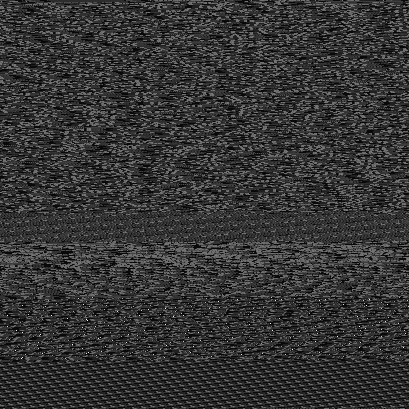

In [63]:
from IPython.display import Image 
Image(filename='asm_image/0cfIE39ihRNo2rkZOw5H.png')

## First 200 Image Pixels

In [64]:
import cv2
imagefeatures = np.zeros((1000, 200)) # 10,868 files

In [65]:
for i, asmfile in enumerate(os.listdir("asmFiles")):
    img = cv2.imread("asm_image/" + asmfile.split('.')[0] + '.png')
    img_arr = img.flatten()[:200]
    imagefeatures[i, :] += img_arr

In [66]:
img_features_name = []
for i in range(200):
    img_features_name.append('pix' + str(i))
imgdf = pd.DataFrame(normalize(imagefeatures, axis = 0), columns = img_features_name)

In [67]:
imgdf['ID'] = result.ID

In [68]:
imgdf.head()

,pix0,pix1,pix2,pix3,pix4,pix5,pix6,pix7,pix8,pix9,...,pix191,pix192,pix193,pix194,pix195,pix196,pix197,pix198,pix199,ID
0,0.033956,0.033956,0.033956,0.026343,0.026343,0.026343,0.027291,0.027291,0.027291,0.025929,...,0.031638,0.031638,0.031638,0.031638,0.031638,0.031638,0.031638,0.031638,0.031638,01azqd4InC7m9JpocGv5
1,0.021694,0.021694,0.021694,0.044286,0.044286,0.044286,0.042405,0.042405,0.042405,0.045756,...,0.031638,0.031638,0.031638,0.031638,0.031638,0.031638,0.031638,0.031638,0.031638,01IsoiSMh5gxyDYTl4CB
2,0.033956,0.033956,0.033956,0.026343,0.026343,0.026343,0.027291,0.027291,0.027291,0.025929,...,0.031638,0.031638,0.031638,0.031638,0.031638,0.031638,0.031638,0.031638,0.031638,01jsnpXSAlgw6aPeDxrU
3,0.033956,0.033956,0.033956,0.026343,0.026343,0.026343,0.027291,0.027291,0.027291,0.025929,...,0.031638,0.031638,0.031638,0.031638,0.031638,0.031638,0.031638,0.031638,0.031638,01kcPWA9K2BOxQeS5Rju
4,0.033956,0.033956,0.033956,0.026343,0.026343,0.026343,0.027291,0.027291,0.027291,0.025929,...,0.031638,0.031638,0.031638,0.031638,0.031638,0.031638,0.031638,0.031638,0.031638,01SuzwMJEIXsK7A8dQbl


In [69]:
#import joblib
joblib.dump(imgdf, 'img_df')

['img_df']

In [70]:
img_df=joblib.load('img_df')

In [71]:
img_df.head()

,pix0,pix1,pix2,pix3,pix4,pix5,pix6,pix7,pix8,pix9,...,pix191,pix192,pix193,pix194,pix195,pix196,pix197,pix198,pix199,ID
0,0.033956,0.033956,0.033956,0.026343,0.026343,0.026343,0.027291,0.027291,0.027291,0.025929,...,0.031638,0.031638,0.031638,0.031638,0.031638,0.031638,0.031638,0.031638,0.031638,01azqd4InC7m9JpocGv5
1,0.021694,0.021694,0.021694,0.044286,0.044286,0.044286,0.042405,0.042405,0.042405,0.045756,...,0.031638,0.031638,0.031638,0.031638,0.031638,0.031638,0.031638,0.031638,0.031638,01IsoiSMh5gxyDYTl4CB
2,0.033956,0.033956,0.033956,0.026343,0.026343,0.026343,0.027291,0.027291,0.027291,0.025929,...,0.031638,0.031638,0.031638,0.031638,0.031638,0.031638,0.031638,0.031638,0.031638,01jsnpXSAlgw6aPeDxrU
3,0.033956,0.033956,0.033956,0.026343,0.026343,0.026343,0.027291,0.027291,0.027291,0.025929,...,0.031638,0.031638,0.031638,0.031638,0.031638,0.031638,0.031638,0.031638,0.031638,01kcPWA9K2BOxQeS5Rju
4,0.033956,0.033956,0.033956,0.026343,0.026343,0.026343,0.027291,0.027291,0.027291,0.025929,...,0.031638,0.031638,0.031638,0.031638,0.031638,0.031638,0.031638,0.031638,0.031638,01SuzwMJEIXsK7A8dQbl


## Important Feature Selection Using Random Forest

In [30]:
def imp_features(data, features, keep):
    rf = RandomForestClassifier(n_estimators = 100, n_jobs = -1)
    rf.fit(data, result_y)
    imp_feature_indx = np.argsort(rf.feature_importances_)[::-1]
    imp_value = np.take(rf.feature_importances_, imp_feature_indx[:20])
    imp_feature_name = np.take(features, imp_feature_indx[:20])
    sns.set()
    plt.figure(figsize = (10, 5))
    ax = sns.barplot(x = imp_feature_name, y = imp_value)
    ax.set_xticklabels(labels = imp_feature_name, rotation = 45)
    sns.set_palette(reversed(sns.color_palette("husl", 10)), 10)
    plt.title('Important Features')
    plt.xlabel('Feature Names')
    plt.ylabel('Importance')
    return imp_feature_indx[:keep]

## Important Features Among Opcode Bi-Gram

In [91]:
op_bi_indxes = imp_features(normalize(opcodebivect, axis = 0), asmopcodebigram(), 200)

In [97]:
op_bi_df = pd.DataFrame.sparse.from_spmatrix(normalize(opcodebivect, axis = 0), columns = asmopcodebigram())
for col in op_bi_df.columns:
    if col not in np.take(asmopcodebigram(), op_bi_indxes):
        op_bi_df.drop(col, axis = 1, inplace = True)

In [99]:
op_bi_df.sparse.to_dense().to_csv('op_bi.csv')

In [100]:
op_bi_df = pd.read_csv('op_bi.csv').drop('Unnamed: 0', axis = 1).fillna(0)

In [101]:
op_bi_df['ID'] = result.ID
op_bi_df.head()

,jmp jmp,jmp mov,jmp push,jmp pop,jmp xor,jmp retn,jmp sub,jmp dec,jmp add,jmp cmp,...,movzx mov,movzx push,movzx xor,movzx sub,movzx or,movzx cmp,movzx jz,movzx lea,movzx movzx,ID
0,0.120238,0.011559,0.001300,0.000000,0.006449,0.00000,0.031909,0.004489,0.049391,0.000336,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,01azqd4InC7m9JpocGv5
1,0.000000,0.001927,0.000650,0.001779,0.001138,0.00162,0.000000,0.000000,0.005811,0.000000,...,0.006219,0.001328,0.000000,0.005598,0.021130,0.001364,0.00000,0.000000,0.000000,01IsoiSMh5gxyDYTl4CB
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.022571,0.010698,0.005598,0.045782,0.016367,0.00943,0.022876,0.005177,01jsnpXSAlgw6aPeDxrU
3,0.000000,0.000301,0.000217,0.000000,0.000759,0.00162,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000345,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,01kcPWA9K2BOxQeS5Rju
4,0.001366,0.003432,0.000867,0.001779,0.000379,0.00000,0.000000,0.000000,0.000000,0.000336,...,0.000592,0.000000,0.001035,0.000700,0.007043,0.015003,0.00000,0.000000,0.001726,01SuzwMJEIXsK7A8dQbl


## Important Features Among Opcode Tri-Gram

In [102]:
op_tri_indxes = imp_features(normalize(opcodetrivect, axis = 0), asmopcodetrigram(), 200)

In [103]:
op_tri_df = pd.DataFrame.sparse.from_spmatrix(normalize(opcodetrivect, axis = 0), columns = asmopcodetrigram())
op_tri_df = op_tri_df.loc[:, np.intersect1d(op_tri_df.columns, np.take(asmopcodetrigram(), op_tri_indxes))]

In [105]:
op_tri_df.sparse.to_dense().to_csv('op_tri.csv')
op_tri_df = pd.read_csv('op_tri.csv').drop('Unnamed: 0', axis = 1).fillna(0)
op_tri_df['ID'] = result.ID
op_tri_df.head()

,add cmp jmp,add cmp pop,add dec or,add mov add,add mov call,add mov cmp,add pop call,add pop mov,add pop pop,add pop retn,...,sub mov lea,sub mov movzx,sub shl push,sub xor pop,xor lea jmp,xor pop jmp,xor pop pop,xor push push,xor sub inc,ID
0,0.000000,0.002934,0.000000,0.005284,0.033581,0.002577,0.0,0.017739,0.001676,0.002246,...,0.051983,0.000000,0.128476,0.030275,0.0,0.0,0.001052,0.011010,0.0,01azqd4InC7m9JpocGv5
1,0.000000,0.005868,0.014228,0.003303,0.000000,0.001289,0.0,0.005913,0.000000,0.000749,...,0.006116,0.024547,0.000000,0.000000,0.0,0.0,0.001052,0.000000,0.0,01IsoiSMh5gxyDYTl4CB
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.016515,0.0,01jsnpXSAlgw6aPeDxrU
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.003058,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,01kcPWA9K2BOxQeS5Rju
4,0.003281,0.000000,0.000000,0.002642,0.000000,0.009450,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000918,0.0,01SuzwMJEIXsK7A8dQbl


## Important Features Among Opcode Tetra-Gram

In [108]:
op_tetra_indxes = imp_features(normalize(opcodetetravect, axis = 0), asmopcodetetragram(), 200)

In [109]:
op_tetra_df = pd.DataFrame.sparse.from_spmatrix(normalize(opcodetetravect, axis = 0), columns = asmopcodetetragram())
op_tetra_df = op_tetra_df.loc[:, np.intersect1d(op_tetra_df.columns, np.take(asmopcodetetragram(), op_tetra_indxes))]

In [110]:
op_tetra_df.sparse.to_dense().to_csv('op_tetra.csv')
op_tetra_df = pd.read_csv('op_tetra.csv').drop('Unnamed: 0', axis = 1).fillna(0)
op_tetra_df['ID'] = result.ID
op_tetra_df.head()

,add jmp mov jmp,add mov cmp jnb,add mov jmp mov,add mov mov add,add mov mov movzx,add mov mov push,add mov movzx mov,add pop call add,add pop lea push,add pop push mov,...,sub mov mov mov,sub mov mov push,sub shl mov or,sub shl push mov,xor cmp cmp jnb,xor lea jmp cmp,xor mov mov mov,xor pop call retn,xor retn mov push,ID
0,0.006994,0.000000,0.003532,0.005958,0.000000,0.003011,0.000000,0.0,0.0,0.0,...,0.012026,0.017061,0.0,0.064786,0.0,0.0,0.002660,0.0,0.0,01azqd4InC7m9JpocGv5
1,0.000000,0.000000,0.001766,0.004767,0.010269,0.004014,0.004865,0.0,0.0,0.0,...,0.013190,0.070681,0.0,0.000000,0.0,0.0,0.004939,0.0,0.0,01IsoiSMh5gxyDYTl4CB
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,01jsnpXSAlgw6aPeDxrU
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.002437,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,01kcPWA9K2BOxQeS5Rju
4,0.003497,0.086074,0.007065,0.069116,0.005134,0.032113,0.004865,0.0,0.0,0.0,...,0.027543,0.075556,0.0,0.000000,0.0,0.0,0.000380,0.0,0.0,01SuzwMJEIXsK7A8dQbl


## Important Features Among Byte Bi-Gram

In [39]:
byte_bi_indxes = imp_features(normalize(byte_bigram_vect, axis = 0), byte_bigram(), 400)

In [40]:
np.save('byte_bi_indx', byte_bi_indxes)
byte_bi_indxes = np.load('byte_bi_indx.npy')

In [42]:
top_byte_bi = np.zeros((1000, 0))
for i in byte_bi_indxes:
    sliced = byte_bigram_vect[:, i].todense()
    top_byte_bi = np.hstack([top_byte_bi, sliced])

In [53]:
byte_bi_df = pd.DataFrame(top_byte_bi, columns = np.take(byte_bigram(), byte_bi_indxes))
byte_bi_df

,a8 25,fd a5,bb f4,52 36,8b ec,2d e7,44 8e,e5 95,a6 da,5a 52,...,00 14,65 20,8b 55,31 00,44 44,45 f8,93 00,47 ee,db 00,00 cf
0,0.014141,0.015270,0.019589,0.012607,0.000234,0.013471,0.011729,0.014873,0.011187,0.003312,...,0.081606,0.001851,0.000291,0.023141,0.002282,0.001183,0.044499,0.039276,0.069426,0.173741
1,0.000000,0.000000,0.003918,0.042863,0.010781,0.000000,0.048594,0.000000,0.000000,0.000000,...,0.001032,0.005336,0.001623,0.000362,0.000027,0.007266,0.000209,0.000000,0.000387,0.001071
2,0.014141,0.021378,0.011753,0.012607,0.004609,0.005388,0.006703,0.007436,0.007458,0.001656,...,0.009677,0.000545,0.002081,0.002950,0.000159,0.001352,0.007131,0.023566,0.007537,0.021952
3,0.005303,0.003054,0.000000,0.000000,0.002578,0.002694,0.000000,0.000000,0.011187,0.002484,...,0.003032,0.001525,0.003996,0.001789,0.000531,0.006590,0.000209,0.007855,0.001063,0.000803
4,0.008838,0.000000,0.003918,0.005043,0.001953,0.008083,0.000000,0.011154,0.007458,0.001656,...,0.000258,0.000109,0.006660,0.000076,0.000000,0.015208,0.000083,0.000000,0.000242,0.000134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.028282,0.045810,0.058766,0.030256,0.007109,0.040413,0.020108,0.044618,0.018645,0.043057,...,0.001032,0.001089,0.000458,0.000266,0.000478,0.002366,0.000459,0.078552,0.000870,0.001740
996,0.001768,0.000000,0.003918,0.005043,0.002734,0.002694,0.005027,0.003718,0.000000,0.001656,...,0.000839,0.001089,0.000083,0.000761,0.010932,0.001690,0.000083,0.003928,0.000531,0.000134
997,0.033584,0.039702,0.039177,0.037820,0.004609,0.043107,0.018432,0.044618,0.052206,0.024841,...,0.001677,0.001416,0.000708,0.000362,0.000212,0.001859,0.000375,0.054987,0.000676,0.001740
998,0.035352,0.054972,0.078355,0.037820,0.004609,0.029636,0.033513,0.037182,0.048477,0.022357,...,0.001161,0.001525,0.000458,0.000228,0.000504,0.001690,0.000542,0.062842,0.000580,0.000937


In [60]:
byte_bi_df.to_csv('byte_bi.csv')
byte_bi_df = pd.read_csv('byte_bi.csv').drop('Unnamed: 0', axis = 1).fillna(0)
byte_bi_df['ID'] = result.ID
byte_bi_df.head()

,a8 25,fd a5,bb f4,52 36,8b ec,2d e7,44 8e,e5 95,a6 da,5a 52,...,65 20,8b 55,31 00,44 44,45 f8,93 00,47 ee,db 00,00 cf,ID
0,0.014141,0.015270,0.019589,0.012607,0.000234,0.013471,0.011729,0.014873,0.011187,0.003312,...,0.001851,0.000291,0.023141,0.002282,0.001183,0.044499,0.039276,0.069426,0.173741,01azqd4InC7m9JpocGv5
1,0.000000,0.000000,0.003918,0.042863,0.010781,0.000000,0.048594,0.000000,0.000000,0.000000,...,0.005336,0.001623,0.000362,0.000027,0.007266,0.000209,0.000000,0.000387,0.001071,01IsoiSMh5gxyDYTl4CB
2,0.014141,0.021378,0.011753,0.012607,0.004609,0.005388,0.006703,0.007436,0.007458,0.001656,...,0.000545,0.002081,0.002950,0.000159,0.001352,0.007131,0.023566,0.007537,0.021952,01jsnpXSAlgw6aPeDxrU
3,0.005303,0.003054,0.000000,0.000000,0.002578,0.002694,0.000000,0.000000,0.011187,0.002484,...,0.001525,0.003996,0.001789,0.000531,0.006590,0.000209,0.007855,0.001063,0.000803,01kcPWA9K2BOxQeS5Rju
4,0.008838,0.000000,0.003918,0.005043,0.001953,0.008083,0.000000,0.011154,0.007458,0.001656,...,0.000109,0.006660,0.000076,0.000000,0.015208,0.000083,0.000000,0.000242,0.000134,01SuzwMJEIXsK7A8dQbl


## Total Features

#### Adding 300 Byte bigram, 200 Opcode Bigram + Trigram + Tetragram (each), first 200 Image Pixels

In [71]:
final_data = pd.concat([result_x, op_bi_df, op_tri_df, op_tetra_df, byte_bi_df,img_df], axis = 1, join = 'inner')
final_data = final_data.drop('ID', axis = 1)
final_data.head()

,0,1,2,3,4,5,6,7,8,9,...,pix190,pix191,pix192,pix193,pix194,pix195,pix196,pix197,pix198,pix199
0,601905,3905,2816,3832,3345,3242,3650,3201,2965,3205,...,0.031638,0.031638,0.031638,0.031638,0.031638,0.031638,0.031638,0.031638,0.031638,0.031638
1,39755,8337,7249,7186,8663,6844,8420,7589,9291,358,...,0.031638,0.031638,0.031638,0.031638,0.031638,0.031638,0.031638,0.031638,0.031638,0.031638
2,93506,9542,2568,2438,8925,9330,9007,2342,9107,2457,...,0.031638,0.031638,0.031638,0.031638,0.031638,0.031638,0.031638,0.031638,0.031638,0.031638
3,21091,1213,726,817,1257,625,550,523,1078,473,...,0.031638,0.031638,0.031638,0.031638,0.031638,0.031638,0.031638,0.031638,0.031638,0.031638
4,19764,710,302,433,559,410,262,249,422,223,...,0.031638,0.031638,0.031638,0.031638,0.031638,0.031638,0.031638,0.031638,0.031638,0.031638


In [72]:
final_data.to_csv('final_data.csv')
final_data = pd.read_csv('final_data.csv')